In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import glob
import shutil
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

#from sklearn.metrics import confusion_matrix

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from zipfile import ZipFile
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip


In [3]:
with ZipFile('../input/dogs-vs-cats-redux-kernels-edition/train.zip', 'r') as train_path:
    train_path.extractall()
    
with ZipFile('../input/dogs-vs-cats-redux-kernels-edition/test.zip', 'r') as test_path:
    test_path.extractall()

cat.1292.jpg


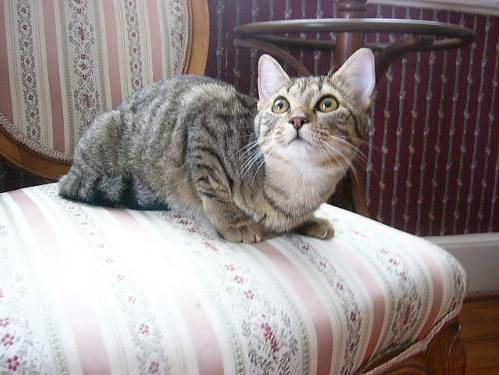

In [4]:
print(os.listdir('train')[0])
load_img('train/' + os.listdir('train')[0])

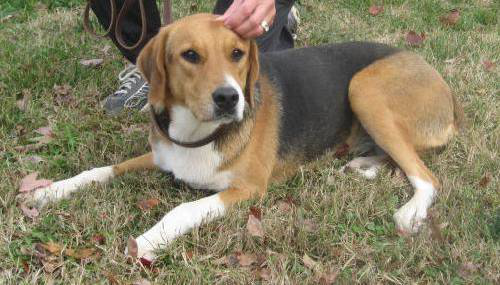

In [5]:
load_img('test/'+os.listdir('test')[0])

In [6]:
print('Training file length:', len(os.listdir('/kaggle/working/train')))
print('Test file length:', len(os.listdir('/kaggle/working/test')))

Training file length: 25000
Test file length: 12500


In [7]:
dog_count = 0
for i in os.listdir('train'):
    if 'dog' in i:
        dog_count += 1
print(dog_count)

12500


50% of the images in the training directory are dogs while the other half are cat images

# Creating Directory

Let's create a directory called 'dogs-vs-cats' that has subdirectories called 'train' and 'valid' that contains a random assortment of dog and cat images

In [8]:
path_name = 'dogs-vs-cats'
if os.path.isdir(path_name+'/dog') is False:
    os.makedirs(path_name+'/dog')
    os.makedirs(path_name+'/cat')
    
    for i in os.listdir('train'):
        if 'dog' in i:
            shutil.move('/kaggle/working/train/'+i, path_name+'/dog')
        if 'cat' in i:
            shutil.move('/kaggle/working/train/'+i, path_name+'/cat')

I want to double check that the shape of these images meets my expecations

In [9]:
os.listdir('dogs-vs-cats/cat')

['cat.1292.jpg',
 'cat.10460.jpg',
 'cat.1806.jpg',
 'cat.5664.jpg',
 'cat.12189.jpg',
 'cat.7042.jpg',
 'cat.9021.jpg',
 'cat.7337.jpg',
 'cat.3353.jpg',
 'cat.3162.jpg',
 'cat.11967.jpg',
 'cat.3564.jpg',
 'cat.3372.jpg',
 'cat.6274.jpg',
 'cat.5973.jpg',
 'cat.6818.jpg',
 'cat.1048.jpg',
 'cat.6702.jpg',
 'cat.3411.jpg',
 'cat.9061.jpg',
 'cat.1322.jpg',
 'cat.984.jpg',
 'cat.1176.jpg',
 'cat.587.jpg',
 'cat.7253.jpg',
 'cat.3032.jpg',
 'cat.6539.jpg',
 'cat.4514.jpg',
 'cat.11468.jpg',
 'cat.1123.jpg',
 'cat.369.jpg',
 'cat.2398.jpg',
 'cat.10743.jpg',
 'cat.1844.jpg',
 'cat.731.jpg',
 'cat.5690.jpg',
 'cat.8440.jpg',
 'cat.6.jpg',
 'cat.8534.jpg',
 'cat.7826.jpg',
 'cat.11975.jpg',
 'cat.679.jpg',
 'cat.3583.jpg',
 'cat.6126.jpg',
 'cat.659.jpg',
 'cat.3530.jpg',
 'cat.6315.jpg',
 'cat.8905.jpg',
 'cat.131.jpg',
 'cat.676.jpg',
 'cat.4627.jpg',
 'cat.3438.jpg',
 'cat.11669.jpg',
 'cat.8848.jpg',
 'cat.3099.jpg',
 'cat.7684.jpg',
 'cat.7878.jpg',
 'cat.1002.jpg',
 'cat.11145.jpg',


In [10]:
dogs = os.listdir('dogs-vs-cats/cat')
cats = os.listdir('dogs-vs-cats/dog')

In [11]:
print(f'Dog directory shape is {len(dogs)} and Cat directory shape is {len(cats)}')

Dog directory shape is 12500 and Cat directory shape is 12500


# Pretrained Models

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

In [13]:
def augment_and_dir(img_size):
    """
    Augment and read image data from directory
    """
    gen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        validation_split=0.2
    )

    train_batches = gen.flow_from_directory(
        directory='dogs-vs-cats',
        target_size=(img_size, img_size),
        class_mode='categorical',
        subset='training',
        batch_size=32,
        shuffle=True,
        seed=42
    )
    
    valid_batches = gen.flow_from_directory(
        directory='dogs-vs-cats',
        target_size=(img_size, img_size),
        class_mode='categorical',
        subset='validation',
        batch_size=1,
        shuffle=True,
        seed=42
    )
    
    test_batches = ImageDataGenerator(
        rescale=1./255
    ).flow_from_directory(
        directory='/kaggle/working',
        classes=['test'],
        target_size=(img_size,img_size),
        class_mode=None,
        batch_size=1,
        shuffle=False,
        seed=42
    )
    
    return train_batches, valid_batches, test_batches

### VGG16 Model

In [14]:
vgg16 = tensorflow.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

58892288/58889256 [==============================] - 0s 0us/step


In [15]:
#vgg16.summary()

In [16]:
vgg16.trainable=False

vgg_model = Sequential()
vgg_model.add(vgg16)
vgg_model.add(Flatten())
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(2, activation='softmax'))

vgg_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
train_batches, valid_batches, test_batches = augment_and_dir(img_size=224)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [18]:
vgg_model.fit_generator(train_batches, validation_data=valid_batches, epochs=10, callbacks=[early_stopping])

Epoch 1/10
625/625 [==============================] - 361s 578ms/step - loss: 0.4201 - accuracy: 0.8393 - val_loss: 0.2587 - val_accuracy: 0.8854
Epoch 2/10
625/625 [==============================] - 354s 566ms/step - loss: 0.2901 - accuracy: 0.8730 - val_loss: 0.2384 - val_accuracy: 0.8974
Epoch 3/10
625/625 [==============================] - 348s 557ms/step - loss: 0.2756 - accuracy: 0.8785 - val_loss: 0.2201 - val_accuracy: 0.9046
Epoch 4/10
625/625 [==============================] - 344s 551ms/step - loss: 0.2637 - accuracy: 0.8860 - val_loss: 0.2587 - val_accuracy: 0.8884
Epoch 5/10
625/625 [==============================] - 343s 548ms/step - loss: 0.2571 - accuracy: 0.8906 - val_loss: 0.2173 - val_accuracy: 0.9064
Epoch 6/10
625/625 [==============================] - 344s 551ms/step - loss: 0.2514 - accuracy: 0.8932 - val_loss: 0.2067 - val_accuracy: 0.9074
Epoch 7/10
625/625 [==============================] - 342s 548ms/step - loss: 0.2356 - accuracy: 0.9025 - val_loss: 0.2029 -

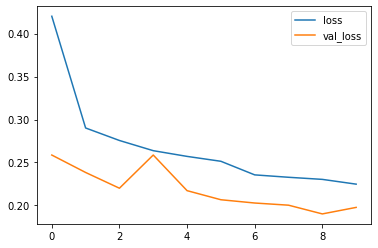

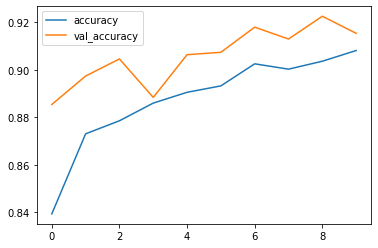

In [19]:
losses = pd.DataFrame(vgg_model.history.history)
losses[['loss','val_loss']].plot()
losses[['accuracy', 'val_accuracy']].plot()

In [20]:
vgg_model.evaluate_generator(valid_batches, verbose=1)

5000/5000 [==============================] - 82s 16ms/step - loss: 0.1958 - accuracy: 0.9188


[0.19579824805259705, 0.9187999963760376]

In [21]:
prediction = vgg_model.predict_generator(test_batches, verbose=1)

12500/12500 [==============================] - 88s 7ms/step


In [22]:
dog_vision = pd.Series(prediction.clip(min=0.02,max=0.98)[:,1])

In [23]:
vgg_submit = pd.DataFrame({'id':test_batches.filenames,'label': dog_vision})
vgg_submit['id'] = vgg_submit.id.str.extract('(\d+)') # \d+ returns 1 or more digits
vgg_submit['id']=pd.to_numeric(vgg_submit['id'])

In [24]:
vgg_submit.to_csv('vgg_submission.csv', index=False)

In [26]:
vgg_submit.head(5)

,id,label
0,1,0.980000
1,10,0.020000
2,100,0.137493
3,1000,0.980000
4,10000,0.980000


In [28]:
vgg_submit[vgg_submit['id'] < 8]

,id,label
0,1,0.980000
3612,2,0.980000
4723,3,0.980000
5834,4,0.980000
6945,5,0.020000
8056,6,0.373558
9167,7,0.020000


# InceptionResnetV2 Model

In [ ]:
inception = tensorflow.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet',
                                                                                include_top=False,
                                                                                input_shape=(299,299,3))

In [ ]:
#inception.summary()

In [ ]:
inception.trainable=False

inception_model = Sequential()
inception_model.add(inception)
inception_model.add(GlobalAveragePooling2D())
inception_model.add(Dense(256, activation='relu'))
inception_model.add(Dropout(0.5))
inception_model.add(Dense(2, activation='softmax'))
inception_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_batches, valid_batches, test_batches = augment_and_dir(img_size=299)

In [ ]:
inception_model.fit_generator(train_batches, validation_data=valid_batches, epochs=10, callbacks=[early_stopping])

In [ ]:
inception_model.evaluate_generator(valid_batches, verbose=1)

In [ ]:
prediction = inception_model.predict_generator(test_batches, verbose=1)

In [ ]:
dog_vision = pd.Series(prediction.clip(min=0.02, max=0.98)[:,1])

In [ ]:
inception_submit = pd.DataFrame({'id':test_batches.filenames,'label': dog_vision})
inception_submit['id'] = inception_submit.id.str.extract('(\d+)')
inception_submit['id']=pd.to_numeric(inception_submit['id'])

In [ ]:
inception_submit.to_csv('inception_submission.csv', index=False)

# Results

* InceptionResnetV2 score: 0.04995
* VGG16 score: 0.17649